In [2]:
#Title: Import CCS Data - "import-ccs-data.py"
#Description: This python script imports and cleans the underlying data from CCS (2018). Run this script by executing "python data/import-ccs-data.py" from the "monetary-policy-heterogeneity" directory.

'''
Data Sources:
1) Real GDP per capita (A939RX0Q048SBEA), GDP Deflator (GDPDEF), and official unemployment rate (UNRATE): https://fred.stlouisfed.org

2) TFP: https://www.frbsf.org/economic-research/indicators-data/total-factor-productivity-tfp/ (Under "Download latest dataset")
    i) See 'quarterly' sheet, series 'dtfp'
    
3) Nonfarm business sector labor share: https://www.bls.gov/lpc/data.htm
    i) Click "Download the complete Major Sector Productivity and Costs dataset"
    ii) Open downloaded folder and see the quarterly excel file "msp_dataset-quarterly-series.xlsx"
    iii) Proceed to sheet "NFBUS, All persons (Level)", column "Labor share (percentage)"

4) CPS Unemployment & Earnings data: https://data.nber.org/cps-basic2/
    i) Under "Downloads," click "In csv format."
    ii) Download csv files for each month one-by-one.
    
    - Note: NBER has been redesigning its website. As a result, the CCS (2018) links are no longer maintained.
    - Previously, NBER provided STATA do-files (http://www.nber.org/data/cps basic progs.html) to clean the raw CPS files from the BLS (http://www.nber.org/data/cps basic.html). 
    - Now, they conveniently provide the ouput of these STATA files in csv format. 
'''

# Load packages
import os
import datetime
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pandas_datareader import get_data_fred
from set_paths import cps_path
import copy
from progressbar import ProgressBar

ModuleNotFoundError: No module named 'pandas_datareader'

In [1]:
os.getcwd()
os.chdir('PATH/monetary-policy-heterogeneity')
os.getcwd()

NameError: name 'os' is not defined

In [3]:
def pull_cps_data(start = '1989-01-01', end = '2021-03-01', directory_path = cps_path):
    '''
    Imports CPS data
    - start = First CPS sample. 
    - end = Last CPS sample.
    - directory_path = Path to save CPS csv's. 
    '''
    cps_dates = pd.period_range(start, end,freq='M')
    for single_date in cps_dates:
        nber_url = "https://data.nber.org/cps-basic2/csv/cpsb{}.csv".format((single_date.strftime('%Y-%m')).replace('-', ''))
        urllib.request.urlretrieve(nber_url, '{}cps-{}.csv'.format(directory_path, (single_date.strftime('%Y-%m')).replace('-', '')))
        os.system('gzip {}cps-{}.csv'.format(directory_path, single_date.strftime('%Y-%m').replace('-', '')))
        print('NBER CPS csv successfully imported: {}'.format(nber_url))

In [56]:
def combine_non_cps_data(fred, fred_unrate, tfp, ls):
    '''
    Combines non-CPS data into single dataframe
    - fred = Per capita GDP & GDP deflator Fred data. 
    - fred_unrate = Unemployment rate Fred data.
    - tfp = SF Fed TFP data.
    - ls = BLS labor share data.
    '''
  
    #Average monthly Fred unemployment rate to quarterly frequency 
    fred_unrate = fred_unrate.resample('QS').last()
    
    #Reset Fred indices and rename columns
    fred_unrate.reset_index(inplace = True)
    fred.reset_index(inplace = True)
    fred_unrate.rename(columns={'DATE': 'date', 'UNRATE': 'unrate'}, inplace=True)
    fred.rename(columns={'DATE': 'date', 'GDPDEF': 'gdpdef', 'A939RX0Q048SBEA': 'pcgdp'}, inplace=True)
   
    #Drop rows in TFP data that correspond to empty rows and summary statistics
    tfp['row_is_none'] = tfp['date'].isna()
    tfp = tfp[(tfp['row_is_none']==0)]
    tfp['row_is_mean'] = (tfp['date'] == 'Full sample mean')
    tfp['row_sum'] = tfp['row_is_mean'].cumsum()
    tfp = tfp[(tfp['row_sum']==0)]

    #Create date variable for TFP data, reset index, and drop unnecessary variables
    tfp['year'] = tfp['date'].str[:4]
    tfp['quarter'] = ((((tfp['date'].str[-1:]).astype('int64'))*3 -2).astype(str)).str.zfill(2)
    tfp['date'] = tfp['year'] + '-' +  tfp['quarter'] + '-' +  '01'
    tfp['date'] = pd.to_datetime(tfp['date'], format='%Y-%m-%d')
    tfp.reset_index(inplace = True, drop=True)
    tfp.drop(['row_is_none', 'row_is_mean', 'row_sum', 'year', 'quarter'], axis=1, inplace=True)

    #Create date variable for the labor share data, rename variable, and drop unnecessary variables
    ls['date'] = ls['Year'].astype(str) + '-' +  (((ls['Qtr'])*3 -2).astype(str)).str.zfill(2) + '-' +  '01'
    ls['date'] = pd.to_datetime(ls['date'], format='%Y-%m-%d')
    ls.drop(['Year', 'Qtr'], axis=1, inplace=True)
    ls.rename(columns={'Labor share': 'labor_share'}, inplace=True) 
    ls.labor_share = ls.labor_share/100
    
    #Combine non-CPS data into single dataframe
    merge_dfs = [fred, fred_unrate, tfp, ls] 
    for df in range(len(merge_dfs)):
        if df == 0:
            ccs = merge_dfs[df]
        else:
            ccs = pd.merge(ccs, merge_dfs[df], on = ['date'], how = 'outer')
            
    #Sort dataframe by date and return non-CPS dataframe        
    ccs = ccs.sort_values(by = 'date')
    return ccs

In [57]:
def pull_ccs_data(start = '1980-01-01', end = str(datetime.datetime.date(datetime.datetime.now())), import_cps = False):
    '''
    Imports CCS data
    - start = Date to start all series. 
    - end = Date to end all series
    '''
    #Real per capita GDP, GDP deflator, and official unemployment rate
    fred_unrate_df = get_data_fred(['UNRATE'], datetime.datetime.strptime(start,'%Y-%m-%d'), datetime.datetime.strptime(end,'%Y-%m-%d'))
    fred_df = get_data_fred(['A939RX0Q048SBEA', 'GDPDEF'], datetime.datetime.strptime(start,'%Y-%m-%d'), datetime.datetime.strptime(end,'%Y-%m-%d'))    
    #TFP series
    tfp_df = pd.read_excel('./data/raw-ccs-data/quarterly_tfp.xlsx', sheet_name = 'quarterly', header = 1, usecols = ['date', 'dtfp'])
    #Labor share 
    ls_df = pd.read_excel('./data/raw-ccs-data/msp_dataset/msp_dataset-quarterly-series.xlsx', sheet_name = 'NFBUS, All persons (Level)', header = 6, usecols = ['Year', 'Qtr', 'Labor share'], skiprows = [7])
    #CPS data
    if import_cps:
        pull_cps_data()
        os.system('chmod -R 550 {}'.format(cps_path))

    #Combine non-CPS data
    ccs = combine_non_cps_data(fred_df, fred_unrate_df, tfp_df, ls_df)   
    ccs.reset_index(inplace = True, drop = True)
    return ccs

In [6]:
#Define cps_quarter, a class that accepts a list of monthly dates and then generates Chang et al. unemployment and earning data for these dates
class cps_quarter:
    
    #Initialize class attributes
    def __init__(self, dates):
        #Set cps_quarter dates
        self.dates = pd.to_datetime(dates, format='%Y%m')
        #Collect dataframe of quarterly CPS data
        self.data = self.clean_cps_data(dates)
        #Define unemployment and earning distributions
        self.unemp_dist, self.earn_dist = self.return_dist() 
        #Calculate each month's (un)weighted unemployment and average log-earning statistics
        self.monthly_unrate_wt = self.calc_monthly_unrate()
        self.monthly_unrate = self.calc_monthly_unrate(weights = False)
        self.monthly_avg_log_earn_wt = self.calc_monthly_earn()
        self.monthly_avg_log_earn = self.calc_monthly_earn(weights = False)
        
    #Clean CPS data files    
    def clean_cps_data(self, cps_files):
        #Loop through all months
        count = 0
        for file in cps_files:
            year = int(file[:4])
            month = int(file[-2:])
            #Import CPS data for given month, handling 1989-1993 and 1994-onward differently
            if year >= 1989 and year < 1994:
                cps_sample = pd.read_csv('CPSPATH/monetary-policy-heterogeneity/cps_data/cps-{}.csv.gz'.format(file), usecols=['a_werntp','a_explf', 'a_fnlwgt','a_ernlwt'])
                cps_sample.rename(columns={'a_explf': 'empstat', 'a_werntp': 'earnweek', 'a_fnlwgt' : 'wtfinl', 'a_ernlwt' : 'earnwt'}, inplace=True)
            elif year >= 1994:
                cps_sample = pd.read_csv('CPSPATH/monetary-policy-heterogeneity/cps_data/cps-{}.csv.gz'.format(file), usecols=['prernwa','prexplf', 'pwsswgt','pworwgt'])
                cps_sample.rename(columns={'prexplf': 'empstat', 'prernwa': 'earnweek', 'pwsswgt' : 'wtfinl', 'pworwgt' : 'earnwt'}, inplace=True)

            #Clean data
            #1) Drop if employment indicator equals -1
            cps_sample.drop(cps_sample[ (cps_sample['empstat'] == -1)].index, inplace = True)
            
            #2) Create employment indicator that equals one if the individual is employed and zero if the individual is unemployed
            emp_dictionary ={1 : 1, 2 : 0, np.nan: np.nan}
            cps_sample['employed'] = cps_sample['empstat'].map(emp_dictionary)
            
            #3) Recode individuals with non-zero and non-missing earnings as employed
            cps_sample.loc[cps_sample.earnweek > 0, 'employed'] = 1
            
            #4) For data from 2017 and beyond, missing earning values are flagged using the -1 and should be recoded
            # Moreover, all earning values must be divided by 100 so that they are comparable to all other years.
            if year >=2017:
                cps_sample.loc[(cps_sample.earnweek == -1),'earnweek']=np.nan
                cps_sample['earnweek'] = cps_sample['earnweek']*1/100

            #5) Recode missing earnings to zero for individuals not employed
            cps_sample.loc[((cps_sample.employed == 0) & (cps_sample['earnweek'].isnull())), 'earnweek'] = 0

            #6) Convert weekly earnings to annual earnings
            cps_sample['earnann'] = cps_sample['earnweek']*52

            #7) Drop unnecessary variables and add date variables
            cps_sample.drop(['empstat', 'earnweek'], axis=1, inplace=True)
            cps_sample['year'] = year
            cps_sample['month'] = month
            
            #Append monthly data to quarterly list
            if count == 0:
                cps_group = cps_sample
                count += 1
            else:
                cps_group = cps_group.append([cps_sample])
        cps_group.reset_index(inplace = True, drop=True)
        return cps_group
    
    #Return unemployment and earnings distributions 
    def return_dist(self):
        cps_df = copy.deepcopy(self.data)
        #Extract unemployment data
        unemp_df = cps_df[["wtfinl", "employed", "year", "month"]]
        #Extract earnings data
        #For earnings data, drop any observations for which earnings are missing, the employment dummy is zero, or earnings are zero
        earn_df = cps_df.drop(cps_df[((cps_df['earnann'].isnull()) | (cps_df.employed == 0) | (cps_df.earnann == 0))].index)
        earn_df = earn_df[["earnwt", "earnann", "year", "month"]]
        return unemp_df, earn_df
    
    #Calculate monthly unemployment rates
    def calc_monthly_unrate(self, weights = True):
        quar_unemp_df = copy.deepcopy(self.unemp_dist)
        if weights:
            quar_unemp_df['wt_sum'] = quar_unemp_df.groupby(['year', 'month'])['wtfinl'].transform('sum')
            quar_unemp_df['wt_emp'] = quar_unemp_df['employed']*quar_unemp_df['wtfinl']/quar_unemp_df['wt_sum']
            month_unrate = 1 - (quar_unemp_df.groupby(['year', 'month'])['wt_emp'].agg('sum')).to_numpy()
        else:
            month_unrate = 1 - (quar_unemp_df.groupby(['year', 'month'])['employed'].agg('mean')).to_numpy()
        return month_unrate
    
    #Calculate monthly average log earnings
    def calc_monthly_earn(self, weights = True):
        quar_earn_df = copy.deepcopy(self.earn_dist)
        quar_earn_df['log_earn'] = np.log(quar_earn_df['earnann'])
        quar_earn_df['log_earn'] = quar_earn_df['log_earn'].replace([np.inf, -np.inf], np.nan)
        if weights:
            quar_earn_df['wt_sum'] = quar_earn_df.groupby(['year', 'month'])['earnwt'].transform('sum')
            quar_earn_df['wt_earn'] = quar_earn_df['log_earn']*quar_earn_df['earnwt']/quar_earn_df['wt_sum']
            month_earn = (quar_earn_df.groupby(['year', 'month'])['wt_earn'].agg('sum')).to_numpy()
        else:
            month_earn = (quar_earn_df.groupby(['year', 'month'])['log_earn'].agg('mean')).to_numpy()
        return month_earn 
    
    #Calculate average quarterly unemployment rate
    def calc_qtr_unrate(self, weight = True):
        if weight:
            qtr_val = copy.deepcopy(self.monthly_unrate_wt)
        else:
            qtr_val = copy.deepcopy(self.monthly_unrate)
        return qtr_val.mean()
    
    #Calculate average quarterly log earnings
    def calc_qtr_earn(self, weight = True):
        if weight:
            qtr_val = copy.deepcopy(self.monthly_avg_log_earn_wt)
        else:
            qtr_val = copy.deepcopy(self.monthly_avg_log_earn)
        return qtr_val.mean()

In [7]:
#Group dates into groups of n, allowing the final group to have less than n dates
def date_grouper(iterable, n = 3):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))

def collect_cps_qtrly(start = '1989-01-01', end = '2017-09-01', qtr_val = 'last', weight = True, append = True):
    #Generate a list of strings containing each month-year between the specified start and end
    collect_cps_dates = pd.period_range(start, end,freq='M')
    collect_cps_date_str = collect_cps_dates.strftime('%Y-%m')
    collect_cps_date_str = [sub.replace('-', '') for sub in collect_cps_date_str]
    
    #Group dates into quarters (or groups of three)
    grouped_dates = list(date_grouper(collect_cps_dates))
    grouped_dates_str = list(date_grouper(collect_cps_date_str))
    
    #Create empty dataframe to which we will append quarterly unemployment and log earnings statistics 
    cps_qtr_df = pd.DataFrame(columns=['date', 'cps_unrate', 'cps_log_earn'])
    
    if append:
        cps_dist = []
        
    #Loop through each quarter
    pbar = ProgressBar()
    for date_count in pbar(range(len(grouped_dates_str))):
        date_tuple = grouped_dates[date_count]
        date_tuple_str = grouped_dates_str[date_count]
        date_tuple_str_len = len(date_tuple_str) - 1
        
        #Generate instance of class cps_quarter and store in list for later use
        cps_sample_qtr = cps_quarter(date_tuple_str)
        if append:
            cps_dist.append(copy.deepcopy(cps_sample_qtr))
        
        #Define which months to use when calculating unemployment and earning statistics
        if (qtr_val == 'average') | (qtr_val == 'first'):
            qtr_stat = 0
        elif qtr_val == 'middle':
            qtr_stat = min(1, date_tuple_str_len)
        elif qtr_val == 'last':
            qtr_stat = min(2, date_tuple_str_len) 
        #Note: Even if we define unemployment and earning statistics using all, the middle, or last month(s), always report the first date of each quarter
        qtr_date =  date_tuple[0]
        if weight:
            if qtr_val == 'average':
                qtr_unrate = cps_sample_qtr.calc_qtr_unrate()
                qtr_earn = cps_sample_qtr.calc_qtr_earn()
            else:
                qtr_unrate = cps_sample_qtr.monthly_unrate_wt[qtr_stat]
                qtr_earn = cps_sample_qtr.monthly_avg_log_earn_wt[qtr_stat]
        else:
            if qtr_val == 'average':
                qtr_unrate = cps_sample_qtr.calc_qtr_unrate(weight = False)
                qtr_earn = cps_sample_qtr.calc_qtr_earn(weight = False)
            else:
                qtr_unrate = cps_sample_qtr.monthly_unrate[qtr_stat]
                qtr_earn = cps_sample_qtr.monthly_avg_log_earn[qtr_stat]                  
                
        #Append quarterly unemployment and log earnings statistics        
        cps_qtr_df = cps_qtr_df.append(pd.DataFrame({'date': [qtr_date], 'cps_unrate': [qtr_unrate], 'cps_log_earn': [qtr_earn]}), ignore_index=True)
    if append:
        return cps_qtr_df, cps_dist
    else:
        return cps_qtr_df

In [58]:
#Pull non-CPS data
ccs_non_cps = pull_ccs_data()

/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Pull CPS data, 
cps_data_unwt, cps_dist_list = collect_cps_qtrly(weight = False)
cps_data_wt = collect_cps_qtrly(append = False)

/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100% |####################################################################################################################|
100% |####################################################################################################################|


In [59]:
#Combine CPS data with Non-CPS data 
cps_data_wt_rf = cps_data_wt
cps_data_unwt_rf = cps_data_unwt

cps_data_wt_rf['date'] = cps_data_wt_rf['date'].astype(str)
cps_data_wt_rf['date'] = pd.to_datetime(cps_data_wt_rf['date'], format='%Y-%m')

cps_data_unwt_rf['date'] = cps_data_unwt_rf['date'].astype(str)
cps_data_unwt_rf['date'] = pd.to_datetime(cps_data_unwt_rf['date'], format='%Y-%m')

ccs_wt = pd.merge(ccs_non_cps, cps_data_wt_rf, on = ['date'], how = 'inner')
ccs_unwt = pd.merge(ccs_non_cps, cps_data_unwt_rf, on = ['date'], how = 'inner')

#Plot
def plot_unrate(ccs_df, title='Unemployment Rates'):
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(ccs_df['date'].astype(str)), ccs_df['cps_unrate'], color='blue', linewidth=4)
    ax.plot(pd.to_datetime(ccs_df['date'].astype(str)), ccs_df['unrate']*1/100, color='red', linewidth=4, linestyle='dashed')
    ax.set(xlabel='Period', ylabel='', title=title)
    ax.set_ylim(0,0.11)

def plot_earn(ccs_df, title='Log Earnings and GDP'):
    ccs_df['npcgdp'] = ccs_df['pcgdp']*ccs_df['gdpdef']*(2/3)*(1/100)
    ccs_df['log_npcgdp'] = np.log(ccs_df['npcgdp'])
    ccs_df['log_npcgdp'] = ccs_df['log_npcgdp'].replace([np.inf, -np.inf], np.nan)
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(ccs_df['date'].astype(str)), ccs_df['cps_log_earn'], color='blue', linewidth=4)
    ax.plot(pd.to_datetime(ccs_df['date'].astype(str)), ccs_df['log_npcgdp'], color='red', linewidth=4, linestyle='dashed')
    ax.set(xlabel='Period', ylabel='', title=title)
    ax.set_ylim(9.5,11)
def plot_earn_gdp(ccs_df, title='Log Earnings/GDP'):
    ccs_df['npcgdp'] = ccs_df['pcgdp']*ccs_df['gdpdef']*(2/3)*(1/100)
    ccs_df['log_npcgdp'] = np.log(ccs_df['npcgdp'])
    ccs_df['log_npcgdp'] = ccs_df['log_npcgdp'].replace([np.inf, -np.inf], np.nan)
    ccs_df['log_earn_gdp'] = ccs_df['cps_log_earn'] -ccs_df['log_npcgdp']
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(ccs_df['date'].astype(str)),  ccs_df['log_earn_gdp'], color='blue', linewidth=4)
    #ax.plot(pd.to_datetime(ccs_df['date'].astype(str)), (ccs_df['labor_share'] - ccs_df['labor_share'].mean())*1/100, color='red', linewidth=4, linestyle='dashed')
    ax.plot(pd.to_datetime(ccs_df['date'].astype(str)), np.log(ccs_df['labor_share']) - (np.log(ccs_df['labor_share'])).mean(), color='red', linewidth=4, linestyle='dashed')
    ax.set(xlabel='Period', ylabel='', title=title)
    ax.set_ylim(-.1,.1)

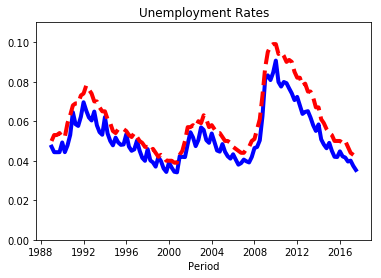

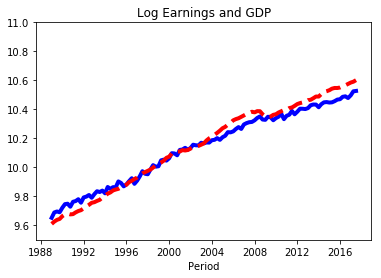

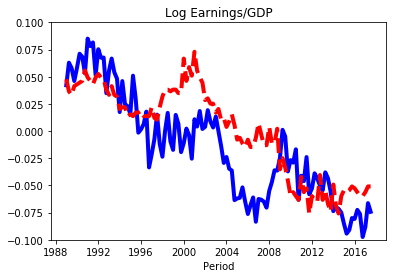

In [60]:
#Figures 1, 12
plot_unrate(ccs_unwt)
plot_earn(ccs_unwt)
plot_earn_gdp(ccs_unwt)

In [ ]:
#Define 
theta_sinh = 1
def inv_sinh(x, theta_sinh = 1):
    return np.log(theta_sinh*x + (theta_sinh^2*x^2+1)^(1/2))/theta_sinh